# Sequence-to-sequence (seq2seq) Part II

In Part I, we have explored Encoder-Decoder model, Transformer (from scratch) to tackle translation task. In notebook, we will explore one of the most useful transformer variants on a different task, text summarization task. We will learn T5 model which is a transformer based model and we will also learn how to fine-tune pretrained models.

In [1]:
# Importing libraries
import os
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import os

# rich: for a better display on terminal
from rich.table import Column, Table
from rich import box
from rich.console import Console

# Importing the T5 modules from huggingface/transformers
from transformers import PegasusTokenizer, PegasusForConditionalGeneration, T5Tokenizer, T5ForConditionalGeneration, BartTokenizer, BartForConditionalGeneration

import nltk

from datasets import load_dataset
from datasets import load_metric

#uncomment this if you are not using puffer
# import os
# os.environ['http_proxy'] = 'http://192.41.170.23:3128'
# os.environ['https_proxy'] = 'http://192.41.170.23:3128'

# !pip3 install datasets
# !pip3 install rich
# !pip3 install SentencePiece
# !pip3 install rouge_score

## What is a Summary?
A summary is a condensed version of an original text, usually a full article or book. Summaries are usually around a paragraph long, and may even be a few paragraphs long depending on the length of the work being condensed.

Summaries are used in variety of situations. For example, you might want to summarize only the main points of a meeting with a co-worker because you're running late for another meeting. Or, let's say you want to introduce a complex design idea. You could begin by summarizing what your design would accomplish, to give key people an overall sense of your plan without overwhelming them. Students might summarize an article for a class, or when preparing and writing research papers, annotated bibliographies and essays. Abstracts and legal brief are also types of summaries.

The "summary" itself has some varieties and approaches.

#### Types of summary

* **Indicative summary** <br>
It looks like a summary of the book. This summary describes what kinds of the story, but not tell all of the stories especially its ends (so indicative summary has only partial information).
* **Informative summary** <br>
In contrast to the indicative summary, the informative summary includes full information of the document.
* **Keyword summary** <br>
Not the text, but the words or phrases from the input document.
* **Headline summary** <br>
Only one line summary.

## Basic Approach

There are mainly two ways to make the summary. Extractive and Abstractive. In short, in extractive summarization sentences are chosen from the article(s) given as input, whereas in abstractive summarization sentences may be generated or a new representation of the article(s) may be output.

### Extractive

* Select relevant **phrases of the input document** and **concatenate** them to form a summary (like "copy-and-paste"). The network calculates the most important sentences from the article and gets them together to provide the most meaningful information from the article.
  * Pros: They are quite robust since they use existing natural-language phrases that are taken straight from the input.
  * Cons: But they lack in flexibility since they cannot use novel words or connectors. They also cannot paraphrase like people sometimes do (less fluent).


### Abstractive

* Generate a summary that keeps original intent. It's just like humans do. The network creates new sentences to encapsulate maximum gist of the article and generates that as output. The sentences in the summary may or may not be contained in the article.
  * Pros: They can use words that were not in the original input. It enables to make more fluent and natural summaries.
  * Cons: But it is also a much harder problem as you now require the model to generate coherent phrases and connectors.

Extractive & Abstractive is not conflicting ways. You can use both to generate the summary. And there are a way collaborate with human.

* Aided Summarization
  * Combines automatic methods with human input.
  * Computer suggests important information from the document, and the human decide to use it or not. It uses information retrieval, and text mining way.


The beginning of the abstractive summarization, [Banko et al. (2000)](http://www.anthology.aclweb.org/P/P00/P00-1041.pdf) suggest to use machine translatation model to abstractive summarization model. As like the machine translation model converts a source language text to a target one, the summarization system converts a source document to a target summary.

Nowadays, **encoder-decoder** model that is one of the neural network models is mainly used in machine translation. So this model is also widely used in abstractive summarization model. [The summarization model that used encoder-decoder model first](http://www.aclweb.org/anthology/N16-1012) achieved state-of-the-art on the two sentence-level summarization dataset, DUC-2004 and Gigaword.

#### Encoder-Decoder Model

The encoder-decoder model is composed of encoder and decoder like its name. The encoder converts an input document to a latent representation (vector), and the decoder generates a summary by using it.

One of the well-known Encoder-Decoder models is T5 which we will be using in this lecture. T5 is one of the most recent and novel transformers model. T5 in many ways is one of its kind transformers architecture that not only gives state of the art results in many NLP tasks, but also has a very radical approach to NLP tasks.
Text-2-Text - According to the graphic taken from the T5 paper. All NLP tasks are converted to a text-to-text problem. Tasks such as translation, classification, summarization and question answering, all of them are treated as a text-to-text conversion problem, rather than seen as separate unique problem statements.
Unified approach for NLP Deep Learning - Since the task is reflected purely in the text input and output, you can use the same model, objective, training procedure, and decoding process to ANY task. Above framework can be used for any task - show Q&A, summarization, etc.

![](images/t5.png)

We will be taking inputs from the T5 paper to prepare our dataset prior to fine tuning and training.



### Preparing the Dataset for data processing: Class
We will start with creation of Dataset class - This defines how the text is pre-processed before sending it to the neural network. This dataset will be used the the Dataloader method that will feed the data in batches to the neural network for suitable training and processing. The Dataloader and Dataset will be used inside the Trainer(). 

#### CustomDataset Dataset Class

* This class is defined to accept the data as input and generate tokenized output that is used by the T5 model for training.

* add_prefix() inside Dataset Class is to add a prefix "summarize: ", this is important when you use T5

* We are using the T5 tokenizer to tokenize the data in the text and ctext column of the dataframe.

* The tokenizer uses the batch_encode_plus method to perform tokenization and generate the necessary outputs, namely: source_id, source_mask from the actual text and target_id and target_mask from the summary text.
To read further into the tokenizer, refer to this document

* The CustomDataset class is used to create 1 dataset for each call, hench is called twice in the Trainer() for training and for validation.

* Training Dataset is used to fine tune the model: 80% of the original data

* Validation Dataset is used to evaluate the performance of the model. The model has not seen this data during training.

In [2]:
from torch.utils.data import Dataset
import torch
import pandas as pd

class Dataset(Dataset):
    """
    Creating a custom dataset for reading the dataset and
    loading it into the dataloader to pass it to the
    neural network for finetuning the model

    """

    def __init__(
        self, data, tokenizer, model_name, source_len, target_len, source_text, target_text, #train = True,
    ):
        """
        Initializes a Dataset class

        Args:yo
            data: Input data
            tokenizer (transformers.tokenizer): Transformers tokenizer
            source_len (int): Max length of source text
            target_len (int): Max length of target text
            source_text (str): column name of source text
            target_text (str): column name of target text
        """
        self.tokenizer = tokenizer
        self.data = data
        self.source_len = source_len
        self.summ_len = target_len
        
        # Xsum contains about 200000+ samples, so lets just take a small portion
        self.source_text = self.data[source_text][:1000]
        if "t5" in model_name:
            self.source_text = self.add_prefix(self.source_text)
        self.target_text = self.data[target_text][1:1000]

    def __len__(self):
        """returns the length of data"""

        return len(self.target_text)

    def __getitem__(self, index):
        """return the input ids, attention masks and target ids"""

        source_text = str(self.source_text[index])
        target_text = str(self.target_text[index])

        # cleaning data so as to ensure data is in string type
        source_text = " ".join(source_text.split())
        target_text = " ".join(target_text.split())

        source = self.tokenizer.batch_encode_plus(
            [source_text],
            max_length=self.source_len,
            pad_to_max_length=True,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        
        target = self.tokenizer.batch_encode_plus(
            [target_text],
            max_length=self.summ_len,
            pad_to_max_length=True,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )

        source_ids = source["input_ids"].squeeze()
        source_mask = source["attention_mask"].squeeze()
        target_ids = target["input_ids"].squeeze()
        target_mask = target["attention_mask"].squeeze()

        return {
            "source_ids": source_ids.to(dtype=torch.long),
            "source_mask": source_mask.to(dtype=torch.long),
            "target_ids": target_ids.to(dtype=torch.long),
            "target_ids_y": target_ids.to(dtype=torch.long),
        }
    
    def add_prefix(self, examples):
        prefix = "summarize: "
        inputs = [prefix + doc for doc in examples]
        return inputs

#### Fine Tuning the Model: Function
Here we define a training function that trains the model on the training dataset created above, specified number of times (EPOCH), An epoch defines how many times the complete data will be passed through the network.

This function is called in the Trainer()

Following events happen in this function to fine tune the neural network:

The epoch, tokenizer, model, device details, testing_ dataloader optimizer and scheduler are passed to the train () when its called from the Trainer()
The dataloader passes data to the model based on the batch size.
language_model_labels are calculated from the target_ids also, source_id and attention_mask are extracted.
The model outputs first element gives the loss for the forward pass.
Loss value is used to optimize the weights of the neurons in the network.
After every 10 step the loss value is logged in the wandb service. This log is then used to generate graphs for analysis.


In [3]:
def train(epoch, tokenizer, model, device, loader, optimizer, scheduler):
    
    """
    Function to be called for training with the parameters passed from main function

    """

    model.train()
    losses = 0
    for _, data in enumerate(loader, 0):
        y = data["target_ids"].to(device, dtype=torch.long)
        y_ids = y[:, :-1].contiguous()
        lm_labels = y[:, 1:].clone().detach()
        lm_labels[y[:, 1:] == tokenizer.pad_token_id] = -100
        ids = data["source_ids"].to(device, dtype=torch.long)
        mask = data["source_mask"].to(device, dtype=torch.long)

        outputs = model(
            input_ids=ids,
            attention_mask=mask,
            decoder_input_ids=y_ids,
            labels=lm_labels,
        )
        loss = outputs[0]
        if _ % 10 == 0:
            print("STEP: ", _,"/",len(loader))
            training_logger.add_row(str(epoch), str(f'{_}/{len(loader)}'), str(loss))
            console.print(training_logger)
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses += loss.detach()

    scheduler.step()
    losses = losses/len(loader)
    return losses

#### Validating the Model Performance: Function
During the validation stage we pass the unseen data(Testing Dataset), trained model, tokenizer and device details to the function to perform the validation run. This step generates new summary for dataset that it has not seen during the training session.

This function is called in the Trainer()

This unseen data is the 20% of the data which was seperated during the Dataset creation stage. During the validation stage the weights of the model are not updated. We use the generate method for generating new text for the summary.

It depends on the Beam-Search coding method developed for sequence generation for models with LM head.

The generated text and originally summary are decoded from tokens to text and returned to the main()



In [4]:
def validate(epoch, tokenizer, model, device, loader):

    """
    Function to evaluate model for predictions

    """
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for _, data in enumerate(loader, 0):
            y = data['target_ids'].to(device, dtype = torch.long)
            ids = data['source_ids'].to(device, dtype = torch.long)
            mask = data['source_mask'].to(device, dtype = torch.long)

            generated_ids = model.generate(
                  input_ids = ids,
                  attention_mask = mask, 
                  max_length=150, 
                  num_beams=2,
                  repetition_penalty=2.5, 
                  length_penalty=1.0, 
                  early_stopping=True
                  )
            preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
            target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True)for t in y]
            if _ % 10==0:
                console.print(f'Completed {_}')

            predictions.extend(preds)
            actuals.extend(target)

    return predictions, actuals

#### Trainer: Function
In Trainer Function dataset, source text, target text, model parameters, output directory and device are passed into.

Inside this function the tokenizer and the pretrained weights of the defined model are downloaded. Moreover our customdataset class is also called here, loader parameters are defined, loaders are created, optimizer is defined and most importanlty, training loop is called. 

After each time the train() is called, validate() is called after. One thing that is still missing is the performance metric.

In the Seq2Seq Part I, we have learnt to implement `BLEU score`, and other evaluation methods were asked to be explored. One of the commonly used metric to evaluate a summarization task is called `ROUGE score`.

#### ROUGE Score

ROUGE stands for Recall-Oriented Understudy for Gisting Evaluation. It is essentially a set of metrics for evaluating automatic summarization of texts as well as machine translations.

It works by comparing an automatically produced summary or translation against a set of reference summaries (typically human-produced). Let’s say that we have the following system and reference summaries:


System Summary (what the machine produced): <br>
`the cat was found under the bed`

Reference Summary (gold standard — usually by humans):<br>
`the cat was under the bed`

If we consider just the individual words, the number of overlapping words between the system summary and reference summary is 6. This, however, does not tell you much as a metric. To get a good quantitative value, we can actually compute the precision and recall using the overlap.

Simply put, recall (in the context of ROUGE) refers to how much of the reference summary the system summary is recovering or capturing. If we are just considering the individual words, it can be computed as:

$$  \big( \frac{number\:of\:overlapping\:words'}{{total\:words\:in\:the\:reference\:summary}} \big) $$ 

$$ \text{Recall} = \big( \frac{6}{6} \big)  = {1.0}$$  

This means that all the words in the reference summary have been captured by the system summary, which indeed is the case for this example.

This looks really good for a text summarization system. But it does not tell you the other side of the story. A machine generated summary (system summary) can be extremely long, capturing all words in the reference summary. But, many of the words in the system summary may be useless, making the summary unnecessarily verbose.

This is where precision comes into play. In terms of precision, what you are essentially measuring is, how much of the system summary was in fact relevant or needed? Precision is measured as:

$$  \big( \frac{number\:of\:overlapping\:words'}{{total\:words\:in\:the\:system\:summary}} \big) $$ 

$$ \text{Precision} = \big( \frac{6}{7} \big)  = {0.86}$$  

Now, let's say System Summary 2: 

`the tiny little cat was found under the big funny bed`

The Precision now becomes:

$$ \text{Precision} = \big( \frac{6}{11} \big)  = {0.55}$$  

Now, this doesn’t look so good, does it? That is because we have quite a few unnecessary words in the summary. The precision aspect becomes really crucial when you are trying to generate summaries that are concise in nature. Therefore, it is always best to compute both the precision and recall and then report the F-Measure.

If your summaries are in some way forced to be concise through some constraints, then you could consider using just the recall, since precision is of less concern in this scenario.

ROUGE-N, ROUGE-S, and ROUGE-L can be thought of as the granularity of texts being compared between the system summaries and reference summaries.

* ROUGE-N — measures unigram, bigram, trigram and higher order n-gram overlap
* ROUGE-L — measures longest matching sequence of words using LCS. An advantage of using LCS is that it does not require consecutive matches but in-sequence matches that reflect sentence level word order. Since it automatically includes longest in-sequence common n-grams, you don’t need a predefined n-gram length.
* ROUGE-S — Is any pair of words in a sentence in order, allowing for arbitrary gaps. This can also be called skip-gram concurrence. For example, skip-bigram measures the overlap of word pairs that can have a maximum of two gaps in between words. As an example, for the phrase “cat in the hat” the skip-bigrams would be “cat in, cat the, cat hat, in the, in hat, the hat”.

### Q1. Please implement Rouge Score as our evaluation metric as a function that is called the for-loop (3 pt)
Hint: similar to BLEU

In [5]:
from rouge_score import rouge_scorer

def compute_metrics(predictions, actuals, tokenizer):
    
    scorer = rouge_scorer.RougeScorer(['rouge1'])
    
    # a dictionary that will contain the results
    rouge = {'precision': [], 'recall': [], 'fmeasure': []}

    # for each of the hypothesis and reference documents pair
    for (p, a) in zip(predictions, actuals):
        # computing the ROUGE
        score = scorer.score(p, a)
        # separating the measurements
        precision, recall, fmeasure = score['rouge1']
        # add them to the proper list in the dictionary
        rouge['precision'].append(precision)
        rouge['recall'].append(recall)
        rouge['fmeasure'].append(fmeasure)

    return rouge

In [6]:
def Trainer(
    dataset, source_text, target_text, model_params, output_dir="outputs/", device = "cuda"
):

    """
    trainer

    """
    
    losses = []
    
    # Set random seeds and deterministic pytorch for reproducibility
    torch.manual_seed(model_params["SEED"])  # pytorch random seed
    np.random.seed(model_params["SEED"])  # numpy random seed
    torch.backends.cudnn.deterministic = True

    # logging
    console.log(f"""[Model]: Loading {model_params["MODEL"]}...\n""")

    # Defining the model. We are using t5-base model and added a Language model layer on top for generation of Summary.
    # tokenzier for encoding the text
    # Further this model is sent to device (GPU/TPU) for using the hardware.
    if "bart" in model_params["MODEL"]:
        tokenizer = BartTokenizer.from_pretrained(f'facebook/{model_params["MODEL"]}')
        model = BartForConditionalGeneration.from_pretrained(f'facebook/{model_params["MODEL"]}')
    elif "t5" in model_params["MODEL"]:
        tokenizer = T5Tokenizer.from_pretrained(model_params["MODEL"])
        model = T5ForConditionalGeneration.from_pretrained(model_params["MODEL"])
    elif "pegasus" in model_params["MODEL"]:
        tokenizer = PegasusTokenizer.from_pretrained(f'google/{model_params["MODEL"]}')
        model = PegasusForConditionalGeneration.from_pretrained(f'google/{model_params["MODEL"]}')
    else:
        raise ValueError("Undefined model")
        
    model = model.to(device)

    # logging
    console.log(f"[Data]: Reading data...\n")

    # Creation of Dataset and Dataloader
    train_dataset = dataset["train"]
    val_dataset = dataset["validation"]
    
    console.print(f"FULL Dataset: {dataset.shape}")
    console.print(f"TRAIN Dataset: {train_dataset.shape}")
    console.print(f"TEST Dataset: {val_dataset.shape}\n")
    
    del dataset
    
    # Creating the Training and Validation dataset for further creation of Dataloader
    training_set = Dataset(
        train_dataset,
        tokenizer,
        model_params["MODEL"],
        model_params["MAX_SOURCE_TEXT_LENGTH"],
        model_params["MAX_TARGET_TEXT_LENGTH"],
        source_text,
        target_text,
#         train = True,
    )
    val_set = Dataset(
        val_dataset,
        tokenizer,
        model_params["MODEL"],
        model_params["MAX_SOURCE_TEXT_LENGTH"],
        model_params["MAX_TARGET_TEXT_LENGTH"],
        source_text,
        target_text,
#         train = False,
    )
    
    del train_dataset, val_dataset
    
    # Defining the parameters for creation of dataloaders
    train_params = {
        "batch_size": model_params["TRAIN_BATCH_SIZE"],
        "shuffle": True,
        "num_workers": 0,
    }

    val_params = {
        "batch_size": model_params["VALID_BATCH_SIZE"],
        "shuffle": False,
        "num_workers": 0,
    }

    # Creation of Dataloaders for testing and validation. This will be used down for training and validation stage for the model.
    training_loader = DataLoader(training_set, **train_params)
    val_loader = DataLoader(val_set, **val_params)
    
    print("TRAIN LOADER: ", len(training_loader))
    print("VAL LOADER: ", len(val_loader))
    
    del train_params, val_params
    
    # Defining the optimizer that will be used to tune the weights of the network in the training session.
    optimizer = torch.optim.Adam(
        params=model.parameters(), lr=model_params["LEARNING_RATE"]
    )
    
    if model_params["SCHEDULER"] == "linear":
        scheduler = torch.optim.lr_scheduler.LinearLR(optimizer)
    
    # Training loop
    console.log(f"[Initiating Fine Tuning]...\n")

    for epoch in range(model_params["TRAIN_EPOCHS"]):

        loss = train(epoch, tokenizer, model, device, training_loader, optimizer, scheduler)
        losses.append(loss.cpu().numpy())

        # evaluating test dataset        
        predictions, actuals = validate(epoch, tokenizer, model, device, val_loader)
        
        final_df = pd.DataFrame({"Generated Text": predictions, "Actual Text": actuals})
        final_df.to_csv(os.path.join(output_dir, f"""predictions_{model_params['MODEL']}_epoch{epoch}.csv"""))
        print("SAVE TO CSV FINISHED")
        
        
        rouge = compute_metrics(predictions, actuals, tokenizer)
        
        rouge_df = pd.DataFrame.from_dict(rouge, orient='index')
        rouge_df.to_csv(os.path.join(output_dir, f"""rouge_{model_params['MODEL']}_epoch{epoch}.csv"""))
        print("SAVE ROUGE TO CSV FINISHED")
    
    console.log(f"[Saving Model]...\n")
    # Saving the model after training
    path = os.path.join(output_dir, "model_files")
    model.save_pretrained(path)
    tokenizer.save_pretrained(path)
    
    # converting list to array
    arr = np.array(losses)
    np.save(os.path.join(output_dir, f"""losses_{model_params['MODEL']}_epoch{model_params['TRAIN_EPOCHS']}"""), arr)

    console.save_text(os.path.join(output_dir, "logs.txt"))

    console.log(f"[Validation Completed.]\n")
    console.print(
        f"""[Model] Model saved @ {os.path.join(output_dir, "model_files")}\n"""
    )
    console.print(
        f"""[Validation] Generation on Validation data saved @ {os.path.join(output_dir,'predictions.csv')}\n"""
    )
    console.print(f"""[Logs] Logs saved @ {os.path.join(output_dir,'logs.txt')}\n""")

### Load data

In [7]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print("configured device: ", device)

configured device:  cuda


In [8]:
data = 'xsum'

if data == 'cnn_dailymail':
    dataset = load_dataset(data, '3.0.0')
    source_text = "article"
    target_text = "highlights"
elif data == "xsum":
    dataset = load_dataset(data)
    source_text = "document"
    target_text = "summary"
else:
    raise ValueError("Undefined dataset")

Using custom data configuration default
Reusing dataset xsum (C:\Users\cedri\.cache\huggingface\datasets\xsum\default\1.2.0\32c23220eadddb1149b16ed2e9430a05293768cfffbdfd151058697d4c11f934)


  0%|          | 0/3 [00:00<?, ?it/s]

### Let's define model parameters specific to T5

### <font color="red">CHANGED THE BATCH SIZE FROM 16 TO 8 HERE TO MAKE IT WORK ON MY OWN PC</font>

In [9]:
# let's define model parameters specific to BART
model_params = {
    "MODEL": "t5-small",  # model_type: t5-base/t5-large
    "TRAIN_BATCH_SIZE": 8,  # training batch size
    "VALID_BATCH_SIZE": 8,  # validation batch size
    "TRAIN_EPOCHS": 3,  # number of training epochs
    "VAL_EPOCHS": 1,  # number of validation epochs
    "LEARNING_RATE": 2e-05,  # learning rate default betas=(0.9, 0.999), eps=1e-08
    "SCHEDULER": "linear",
    "MAX_SOURCE_TEXT_LENGTH": 512,  # max length of source text
    "MAX_TARGET_TEXT_LENGTH": 36,  # max length of target text
    "SEED": 42,  # set seed for reproducibility
}

In [10]:
print(os.getcwd() + '\outputs\\')

C:\Program Files (x86)\Projects - Ongoing\NLP\outputs\


In [11]:
console = Console(record=True)

training_logger = Table(
    Column("Epoch", justify="center"),
    Column("Steps", justify="center"),
    Column("Loss", justify="center"),
    title="Training Status",
    pad_edge=False,
    box=box.ASCII,
)

Trainer(
    dataset=dataset,
    source_text=source_text, 
    target_text=target_text,
    model_params=model_params,
    output_dir=os.getcwd() + '\outputs\\',
    device = device,
)


[20:56:04] [Model]: Loading t5-small...          ]8;id=925316;file://C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_20580\3408253027.py\CreatorTemp/ipykernel_20580/3408253027.py]8;;\:]8;id=42333;file://C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_20580\3408253027.py#18\18]8;;\
                                                                                             

[20:56:18] [Data]: Reading data...               ]8;id=324186;file://C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_20580\3408253027.py\CreatorTemp/ipykernel_20580/3408253027.py]8;;\:]8;id=585936;file://C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_20580\3408253027.py#38\38]8;;\
                                                                                             

FULL Dataset: {'train': (204045, 3), 'validation': (11332, 3), 'test': (11334, 3)}

TRAIN Dataset: (204045, 3)

TEST Dataset: (11332, 3)

TRAIN LOADER:  125
VAL LOADER:  125


[20:56:20] [Initiating Fine Tuning]...          ]8;id=789956;file://C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_20580\3408253027.py\CreatorTemp/ipykernel_20580/3408253027.py]8;;\:]8;id=299664;file://C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_20580\3408253027.py#105\105]8;;\
                                                                                             

STEP:  0 / 125


                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   | 0/125 | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

STEP:  10 / 125


                               Training Status                                
+----------------------------------------------------------------------------+
|Epoch | Steps  |                            Loss                            |
|------+--------+------------------------------------------------------------|
|  0   | 0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125 | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
+----------------------------------------------------------------------------+

STEP:  20 / 125


                               Training Status                                
+----------------------------------------------------------------------------+
|Epoch | Steps  |                            Loss                            |
|------+--------+------------------------------------------------------------|
|  0   | 0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125 | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125 | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
+----------------------------------------------------------------------------+

STEP:  30 / 125


                               Training Status                                
+----------------------------------------------------------------------------+
|Epoch | Steps  |                            Loss                            |
|------+--------+------------------------------------------------------------|
|  0   | 0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125 | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125 | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125 | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
+----------------------------------------------------------------------------+

STEP:  40 / 125


                               Training Status                                
+----------------------------------------------------------------------------+
|Epoch | Steps  |                            Loss                            |
|------+--------+------------------------------------------------------------|
|  0   | 0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125 | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125 | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125 | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125 | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
+----------------------------------------------------------------------------+

STEP:  50 / 125


                               Training Status                                
+----------------------------------------------------------------------------+
|Epoch | Steps  |                            Loss                            |
|------+--------+------------------------------------------------------------|
|  0   | 0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125 | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125 | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125 | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125 | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125 | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
+----------------------------------------------------------------------------+

STEP:  60 / 125


                               Training Status                                
+----------------------------------------------------------------------------+
|Epoch | Steps  |                            Loss                            |
|------+--------+------------------------------------------------------------|
|  0   | 0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125 | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125 | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125 | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125 | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125 | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125 | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
+----------------------------------------------------------------------------+

STEP:  70 / 125


                               Training Status                                
+----------------------------------------------------------------------------+
|Epoch | Steps  |                            Loss                            |
|------+--------+------------------------------------------------------------|
|  0   | 0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125 | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125 | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125 | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125 | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125 | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125 | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125 | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
+----------------------------------------------------------------------------+

STEP:  80 / 125


                               Training Status                                
+----------------------------------------------------------------------------+
|Epoch | Steps  |                            Loss                            |
|------+--------+------------------------------------------------------------|
|  0   | 0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125 | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125 | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125 | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125 | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125 | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125 | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125 | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125 | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
+----------------------------------------------------------------------------+

STEP:  90 / 125


                               Training Status                                
+----------------------------------------------------------------------------+
|Epoch | Steps  |                            Loss                            |
|------+--------+------------------------------------------------------------|
|  0   | 0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125 | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125 | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125 | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125 | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125 | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125 | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125 | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125 | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125 | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
+----------------------------------------------------------------------------+

STEP:  100 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  110 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  120 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

Completed 0

Completed 10

Completed 20

Completed 30

Completed 40

Completed 50

Completed 60

Completed 70

Completed 80

Completed 90

Completed 100

Completed 110

Completed 120

SAVE TO CSV FINISHED
SAVE ROUGE TO CSV FINISHED
STEP:  0 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  10 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.7020, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  20 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.7020, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6206, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  30 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.7020, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6206, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.5501, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  40 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.7020, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6206, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.5501, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6147, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  50 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.7020, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6206, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.5501, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6147, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.4470, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  60 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.7020, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6206, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.5501, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6147, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.4470, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.4128, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  70 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.7020, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6206, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.5501, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6147, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.4470, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.4128, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5632, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  80 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.7020, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6206, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.5501, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6147, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.4470, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.4128, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5632, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7657, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  90 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.7020, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6206, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.5501, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6147, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.4470, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.4128, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5632, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7657, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4529, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  100 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.7020, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6206, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.5501, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6147, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.4470, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.4128, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5632, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7657, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4529, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(4.9634, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  110 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.7020, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6206, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.5501, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6147, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.4470, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.4128, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5632, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7657, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4529, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(4.9634, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.6437, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  120 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.7020, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6206, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.5501, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6147, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.4470, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.4128, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5632, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7657, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4529, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(4.9634, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.6437, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.9752, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

Completed 0

Completed 10

Completed 20

Completed 30

Completed 40

Completed 50

Completed 60

Completed 70

Completed 80

Completed 90

Completed 100

Completed 110

Completed 120

SAVE TO CSV FINISHED
SAVE ROUGE TO CSV FINISHED
STEP:  0 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.7020, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6206, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.5501, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6147, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.4470, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.4128, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5632, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7657, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4529, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(4.9634, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.6437, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.9752, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.0796, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  10 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.7020, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6206, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.5501, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6147, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.4470, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.4128, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5632, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7657, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4529, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(4.9634, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.6437, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.9752, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.0796, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.1159, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  20 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.7020, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6206, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.5501, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6147, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.4470, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.4128, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5632, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7657, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4529, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(4.9634, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.6437, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.9752, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.0796, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.1159, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(4.9573, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  30 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.7020, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6206, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.5501, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6147, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.4470, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.4128, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5632, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7657, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4529, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(4.9634, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.6437, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.9752, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.0796, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.1159, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(4.9573, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 30/125  | tensor(5.1663, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  40 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.7020, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6206, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.5501, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6147, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.4470, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.4128, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5632, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7657, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4529, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(4.9634, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.6437, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.9752, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.0796, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.1159, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(4.9573, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 30/125  | tensor(5.1663, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 40/125  | tensor(4.9444, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  50 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.7020, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6206, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.5501, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6147, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.4470, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.4128, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5632, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7657, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4529, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(4.9634, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.6437, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.9752, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.0796, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.1159, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(4.9573, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 30/125  | tensor(5.1663, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 40/125  | tensor(4.9444, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 50/125  | tensor(5.2201, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  60 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.7020, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6206, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.5501, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6147, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.4470, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.4128, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5632, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7657, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4529, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(4.9634, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.6437, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.9752, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.0796, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.1159, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(4.9573, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 30/125  | tensor(5.1663, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 40/125  | tensor(4.9444, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 50/125  | tensor(5.2201, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 60/125  | tensor(5.2388, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  70 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.7020, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6206, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.5501, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6147, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.4470, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.4128, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5632, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7657, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4529, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(4.9634, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.6437, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.9752, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.0796, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.1159, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(4.9573, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 30/125  | tensor(5.1663, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 40/125  | tensor(4.9444, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 50/125  | tensor(5.2201, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 60/125  | tensor(5.2388, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 70/125  | tensor(4.9634, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  80 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.7020, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6206, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.5501, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6147, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.4470, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.4128, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5632, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7657, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4529, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(4.9634, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.6437, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.9752, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.0796, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.1159, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(4.9573, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 30/125  | tensor(5.1663, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 40/125  | tensor(4.9444, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 50/125  | tensor(5.2201, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 60/125  | tensor(5.2388, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 70/125  | tensor(4.9634, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 80/125  | tensor(5.2895, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  90 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.7020, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6206, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.5501, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6147, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.4470, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.4128, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5632, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7657, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4529, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(4.9634, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.6437, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.9752, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.0796, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.1159, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(4.9573, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 30/125  | tensor(5.1663, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 40/125  | tensor(4.9444, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 50/125  | tensor(5.2201, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 60/125  | tensor(5.2388, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 70/125  | tensor(4.9634, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 80/125  | tensor(5.2895, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 90/125  | tensor(5.0735, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  100 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.7020, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6206, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.5501, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6147, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.4470, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.4128, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5632, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7657, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4529, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(4.9634, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.6437, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.9752, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.0796, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.1159, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(4.9573, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 30/125  | tensor(5.1663, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 40/125  | tensor(4.9444, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 50/125  | tensor(5.2201, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 60/125  | tensor(5.2388, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 70/125  | tensor(4.9634, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 80/125  | tensor(5.2895, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 90/125  | tensor(5.0735, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 100/125 | tensor(4.9074, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  110 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.7020, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6206, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.5501, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6147, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.4470, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.4128, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5632, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7657, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4529, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(4.9634, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.6437, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.9752, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.0796, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.1159, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(4.9573, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 30/125  | tensor(5.1663, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 40/125  | tensor(4.9444, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 50/125  | tensor(5.2201, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 60/125  | tensor(5.2388, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 70/125  | tensor(4.9634, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 80/125  | tensor(5.2895, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 90/125  | tensor(5.0735, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 100/125 | tensor(4.9074, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 110/125 | tensor(5.2607, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

STEP:  120 / 125


                                Training Status                                
+-----------------------------------------------------------------------------+
|Epoch |  Steps  |                            Loss                            |
|------+---------+------------------------------------------------------------|
|  0   |  0/125  | tensor(6.2060, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 10/125  | tensor(6.0331, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 20/125  | tensor(6.0198, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 30/125  | tensor(6.3243, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 40/125  | tensor(6.0157, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 50/125  | tensor(5.3991, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 60/125  | tensor(5.8357, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 70/125  | tensor(6.0591, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 80/125  | tensor(5.6659, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 90/125  | tensor(5.6208, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 100/125 | tensor(5.3076, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 110/125 | tensor(5.4850, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   | 120/125 | tensor(5.3753, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  0/125  | tensor(5.7506, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 10/125  | tensor(5.7020, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 20/125  | tensor(5.6206, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 30/125  | tensor(5.5501, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 40/125  | tensor(5.6147, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 50/125  | tensor(5.4470, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 60/125  | tensor(5.4128, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 70/125  | tensor(5.5632, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 80/125  | tensor(5.7657, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 90/125  | tensor(5.4529, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 100/125 | tensor(4.9634, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 110/125 | tensor(5.6437, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   | 120/125 | tensor(4.9752, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  0/125  | tensor(5.0796, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 10/125  | tensor(5.1159, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 20/125  | tensor(4.9573, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 30/125  | tensor(5.1663, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 40/125  | tensor(4.9444, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 50/125  | tensor(5.2201, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 60/125  | tensor(5.2388, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 70/125  | tensor(4.9634, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 80/125  | tensor(5.2895, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 90/125  | tensor(5.0735, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 100/125 | tensor(4.9074, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 110/125 | tensor(5.2607, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   | 120/125 | tensor(5.0027, device='cuda:0', grad_fn=<NllLossBackward0>)|
+-----------------------------------------------------------------------------+

Completed 0

Completed 10

Completed 20

Completed 30

Completed 40

Completed 50

Completed 60

Completed 70

Completed 80

Completed 90

Completed 100

Completed 110

Completed 120

SAVE TO CSV FINISHED
SAVE ROUGE TO CSV FINISHED


[21:12:41] [Saving Model]...                    ]8;id=924397;file://C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_20580\3408253027.py\CreatorTemp/ipykernel_20580/3408253027.py]8;;\:]8;id=747080;file://C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_20580\3408253027.py#126\126]8;;\
                                                                                             

[21:12:44] [Validation Completed.]              ]8;id=231842;file://C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_20580\3408253027.py\CreatorTemp/ipykernel_20580/3408253027.py]8;;\:]8;id=495568;file://C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_20580\3408253027.py#138\138]8;;\
                                                                                             

[Model] Model saved @ C:\Program Files (x86)\Projects - Ongoing\NLP\outputs\model_files

[Validation] Generation on Validation data saved @ C:\Program Files (x86)\Projects - 
Ongoing\NLP\outputs\predictions.csv

[Logs] Logs saved @ C:\Program Files (x86)\Projects - Ongoing\NLP\outputs\logs.txt

#### But is ROUGE score the best metric to evaluatate a summary?

Here are examples of the generated text. Let's take a closer look at the results.

##### Example 1:

![](images/generatedexample.png)

At the highlighted row, you will notice that in the Generated Text, it exists `Graeme Roy`, while the Actual Summary it is `Jason Roy`

##### Example 2:

![](images/generatedtext.png)

![](images/actualtext.png)

You can see that the name `Yvette Cooper` is contained in the sample **8th** of the Actual Summary, but it appeared in the sample **71st** of the Generated Text.

This problem is called **Name Entity Halluciation**  which is one of comon problems found in Text Summarization task. Since summarization models are optimized to generate summaries that highly overlap with human references, the faithfulness of the summary is not guaranteed. ROUGE Score is insensitive to semantic errors.

These n-gram based approaches weight all portions of the text equally, even when only a small fraction of the n-grams carry most of the semantic content. As a result, factual inconsistency caused by small changes may be drowned out by otherwise high n-gram overlap. 

Another type of problem is called **Factual Consistency** <br>
For example: <br>
the sentence: `My name is Beau.` and <br> 
the sentence: `My name is not Beau.` <br>
share nearly all unigrams and bigrams despite having the opposite meaning. 

### Q2. Please spend some time explore 2 useful metrices that can be used to evaluate summary. Explain what they are briefly and explain how they could be useful and why could they not. (1 pt)

2 other common metrics we use are:

* Mean Average Precision (MAP) 
Simply calculates the mean precision across each retrieved result.
Extrinsic evaluation that we use to measure an actual task, computationally expensive and slow

* Perplexity
A probabilistic model to evaluate how confused the model is
An intrinsic evaluation method to evaluate the language model without any specific final task in mind

### Reference:
https://paperswithcode.com/method/t5#:~:text=T5%2C%20or%20Text%2Dto%2D,to%20generate%20some%20target%20text.

In [1]:
import torch
def noise(size):
    n = torch.randn(size, 100)
    if torch.cuda.is_available(): return n.cuda() 
    return n

torch.Size([100, 100])


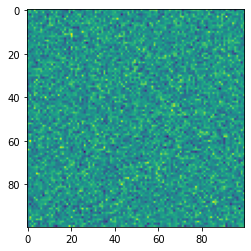

In [7]:
test = noise(100)
print(test.size())
import matplotlib.pyplot as plt

plt.imshow(test.cpu().numpy())